# Ames Housing Prices

## Purpose of the Analysis:

### Find out which Variables Strongly Affect the Housing Prices

The goal of this project is to determine which variables most strongly correlate to the determination of the housing prices in Ames, Iowa. After conducting EDA, multi-linear regression is conducted on the data. The loss from our chosen loss function, RMSE, will be compared to each iteration of the regression to further improve the model.

The file codebook.txt in the repository gives a description of what each independent variable is in the data.

The data of the houses was already split into the training and test dataset, so there is no need to split the training dataset in the analysis.

Some of the ideas presented in this project comes from the Data 200 Course at UC Berkeley. The link to the course is here: http://www.ds100.org/su20/

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import linear_model as lm
from sklearn.base import clone

full_data = pd.read_csv('https://raw.githubusercontent.com/benchang123/Ames-Housing/master/ames.csv')

training_data, test_data = train_test_split(full_data, random_state=42, test_size=0.2)

training_data.shape

(1600, 82)

## EDA

We will do EDA on the variables where it is easy to see if there is a correlation between a variable and the sales price. Later on, we will do some feature engineering to explore the relation of other variables.

First, we will see the amount of missing data in each column and drop those that have too many to the point were it isn't meaningful to analyze them.

In [111]:
nanmean=training_data.isna().mean()*100
nan=nanmean[nanmean>25].sort_values(ascending=False)
print(nan)

training_data.drop(columns=nan.index,inplace=True)

Pool_QC         99.5000
Misc_Feature    96.0000
Alley           93.9375
Fence           80.6250
Fireplace_Qu    48.6875
dtype: float64


C:\Users\bench\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The joint plot was made to see of there are any outliers. We can see thaat there are two outliers where the living area is greater than 500 sq. ft and one where the sales price is greater than $700,000.

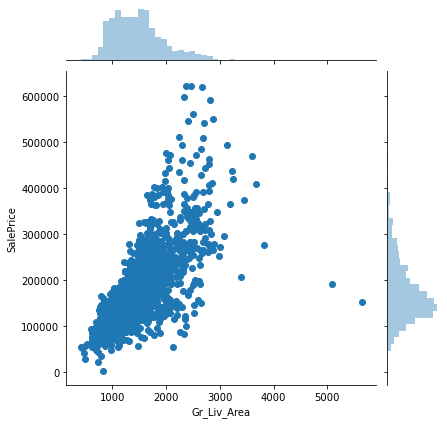

In [112]:
training_data.columns.values

sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
);

Upon looking at the data more, the two outliers exist because they were partial sales. Therefore, it is our best interest to remove the outliers to prevent our regression from inaccurately fitting. 

In [113]:
training_data.loc[training_data['Gr_Liv_Area']>5000,['Sale_Condition','SalePrice']]

,Sale_Condition,SalePrice
1471,Partial,190950
1014,Partial,152200


In [114]:
def remove_outliers(data, variable, upper):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      data frame with outliers removed
    """  
    return data.loc[(data[variable] < upper), :]

training_data = remove_outliers(training_data, 'Gr_Liv_Area', 5000)

It is a good idea to see the distribution of neighborhood that the data encompasses.

<AxesSubplot:xlabel='Neighborhood'>

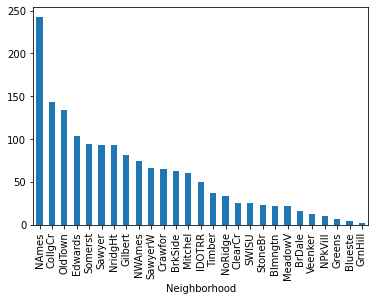

In [115]:
training_data.groupby('Neighborhood').size().sort_values(ascending=False).plot(kind='bar')

We will see the type of data is in each variable.

In [116]:
training_data.dtypes.value_counts()

object     38
int64      30
float64     9
dtype: int64

We can then calculate the correlation between the Sales Price and the numerical variables

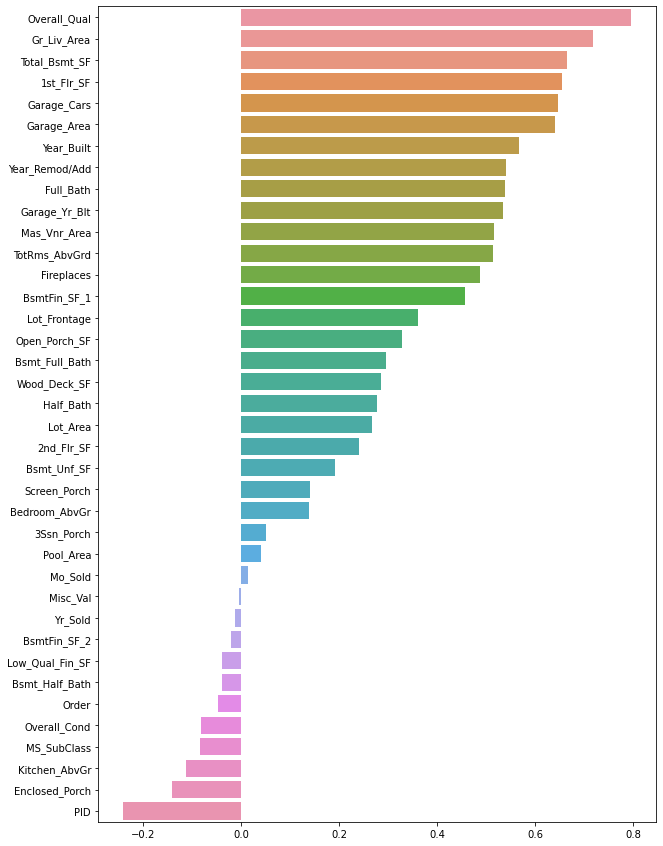

In [117]:
num_cols = training_data.dtypes[(training_data.dtypes == 'int64') | (training_data.dtypes == 'float64')].index
corr_df = training_data.loc[:,num_cols].corr()

sale_price_corr = corr_df['SalePrice'].drop('SalePrice',axis=0).sort_values(ascending=False)
ax = plt.subplots(figsize=(10,15))
ax = sns.barplot(y=sale_price_corr.keys(),x=sale_price_corr.values)

There is some interesting remarks from the barplot. Intuitively, one can expect that if there are more bedrooms, the sale price wil be higher. However, from creating a scatter plot, there doesn't seem to be a clear correlation. 

<AxesSubplot:xlabel='Bedroom_AbvGr', ylabel='SalePrice'>

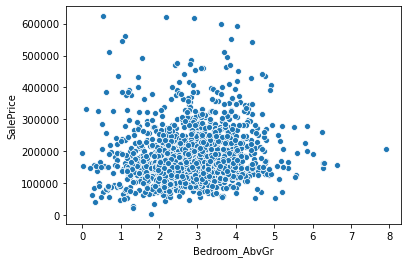

In [118]:
noise = np.random.normal(0,0.5,training_data.shape[0])
training_data_2=training_data
training_data_2['Bedroom_AbvGr']=training_data_2['Bedroom_AbvGr']+noise
sns.scatterplot(data=training_data_2,x='Bedroom_AbvGr',y='SalePrice')

The overall quality of the house (rated 1-10) seemed to have the highest correlation. Let's see how the scatter plot looks like.

<AxesSubplot:xlabel='Overall_Qual', ylabel='SalePrice'>

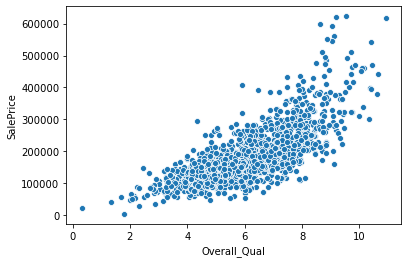

In [119]:
training_data_2=training_data
training_data_2['Overall_Qual']=training_data_2['Overall_Qual']+noise
sns.scatterplot(data=training_data_2,x='Overall_Qual',y='SalePrice')

<AxesSubplot:xlabel='Gr_Liv_Area'>

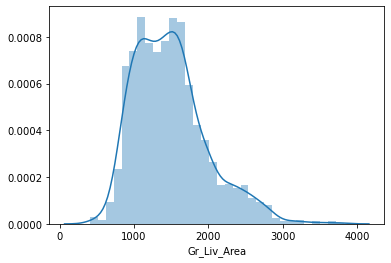

In [120]:
sns.distplot(training_data['Gr_Liv_Area'])

From initial analysis, we can use the above grade living area square feet and overall quality of the house as part of our linear regression. We will now explore variables where feature engineering is required.

## Feature Engineering

Given the data for the number of bathrooms, We can approximate the total number of bathrooms as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

*From Data 100 Notebook

In [121]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    with_bathrooms['TotalBathrooms']=with_bathrooms[bath_vars].fillna(0)@weights
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

We can then create a scatter plot that tells us the number of total bathrooms vs the Sale Price and notice that there is a slighty positive correlation.

<AxesSubplot:xlabel='TotalBathrooms', ylabel='SalePrice'>

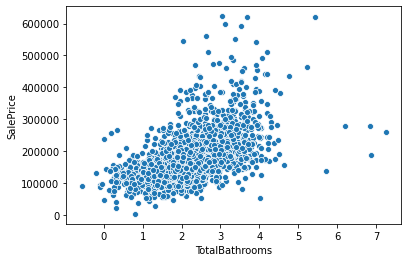

In [122]:
training_data_2=training_data
training_data_2['TotalBathrooms']=training_data_2['TotalBathrooms']+noise
sns.scatterplot(data=training_data_2,x='TotalBathrooms',y='SalePrice')

Next, houses that are in rich neighborhoods are likely to be more expensive, given the safety of the area. We will take the top 3 neighorhoods.

* Idea from Data 100 Notebook 

In [123]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood').agg(metric).sort_values('SalePrice',ascending=False).iloc[0:n].index.tolist()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NoRidge', 'NridgHt']

The following code will add the feature to the dataset.

In [124]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data['in_rich_neighborhood'] = data['Neighborhood'].isin(neighborhoods).astype('category')
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)
training_data

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Lot_Shape,Land_Contour,Utilities,...,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms,in_rich_neighborhood
968,1438,907181140,60,RL,68.0,9179,Pave,IR1,Lvl,AllPub,...,0,0,0,6,2008,WD,Abnorml,185200,4.049439,False
240,340,924151040,20,RL,76.0,9892,Pave,Reg,Lvl,AllPub,...,0,0,0,2,2010,WD,Normal,275300,2.853388,False
819,1225,534477080,50,RL,80.0,9600,Pave,Reg,Lvl,AllPub,...,0,0,0,4,2008,WD,Abnorml,110900,0.410048,False
692,1029,527358120,20,RL,104.0,11361,Pave,Reg,Lvl,AllPub,...,189,0,0,5,2008,COD,Abnorml,172300,2.448498,False
420,614,534431130,20,RL,68.0,9768,Pave,Reg,Lvl,AllPub,...,0,0,0,2,2009,WD,Normal,130900,2.920535,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1670,527404150,20,RL,NaN,7340,Pave,IR1,Lvl,AllPub,...,0,0,0,6,2007,WD,Normal,103000,0.319840,False
1294,1924,535177020,20,RL,70.0,9100,Pave,Reg,Lvl,AllPub,...,0,0,0,6,2007,WD,Normal,113000,0.962280,False
860,1293,902109110,50,RM,63.0,11426,Pave,Reg,Lvl,AllPub,...,0,0,0,6,2008,WD,Normal,207500,2.854327,False
1459,2164,907414070,20,RL,65.0,8769,Pave,Reg,Lvl,AllPub,...,0,0,0,10,2007,WD,Normal,166800,3.015246,False


In [125]:
def ohe_column(data,column):
    column_ohe=pd.get_dummies(data[column],drop_first=True,prefix=column)
    data=pd.concat([data, column_ohe], axis=1)
    return data

In [126]:
training2=ohe_column(training_data,'Functional')
ohe_column(training2,'Exter_Qual')

pd.get_dummies(training_data["Functional"],drop_first=True,prefix="Functional")

,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ
968,0,0,0,0,0,0,1
240,0,0,0,0,0,0,1
819,0,0,0,0,0,0,1
692,0,0,0,0,0,0,1
420,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1130,0,0,0,0,0,0,1
1294,0,0,0,0,0,0,1
860,0,0,0,1,0,0,0
1459,0,0,0,0,0,0,1


To lower the error of our fit, it would be good to see how many variables is optimal to use before the cross-validation error increases (i.e. bias-variance tradeoff).

We first define the RMSE.

In [127]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual-predicted)**2))

We then have an algorithm to see the optimal amount of features for our model. I will strictly use  a sorted list of the highest correlated numerical variables to the Sale Price.

*Borrowed from Data 200*

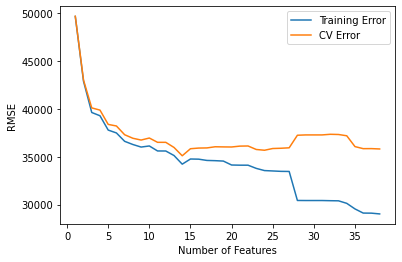

In [153]:
train_error_vs_N = []
cv_error_vs_N = []
linear_model=lm.LinearRegression()
range_of_num_features = range(1, sale_price_corr.shape[0] + 1)

for N in range_of_num_features:
    sale_price_corr_first_N_features = sale_price_corr.iloc[:N]
    saleprice=training_data['SalePrice'].drop(training_data.index[training_data[sale_price_corr.iloc[:N].index].isnull().any(1)])
    indepVar=training_data[sale_price_corr_first_N_features.index].dropna()
    
    cv_results = cross_validate(linear_model, indepVar, saleprice, cv=4,scoring=('r2', 'neg_root_mean_squared_error'),return_train_score=True)
    
    train_error_overfit =-np.mean(cv_results['train_neg_root_mean_squared_error'])
    test_error_overfit=-np.mean(cv_results['test_neg_root_mean_squared_error'])
    train_error_vs_N.append(train_error_overfit)
    cv_error_vs_N.append(test_error_overfit)
    
sns.lineplot(range_of_num_features, train_error_vs_N)
sns.lineplot(range_of_num_features, cv_error_vs_N)
plt.legend(["Training Error", "CV Error"])
plt.xlabel("Number of Features")
plt.ylabel("RMSE");

Further illustration shows exactly where the dip occurs before the RMSE rises again. 

In [154]:
print(cv_error_vs_N[10:15])

[36503.85854517188, 36503.8503064565, 35968.444193770505, 35098.69929470628, 35835.07540458762]


From the 14 variables, it is important to take out variables that are dependent on each other. A heat map with the correlation between the variables were made and we can see that for example, the amount of cars you can fit into a garage is highly correlated to the garage area, which is intuitive. Therefore, we need to delete one of the variables.

<AxesSubplot:>

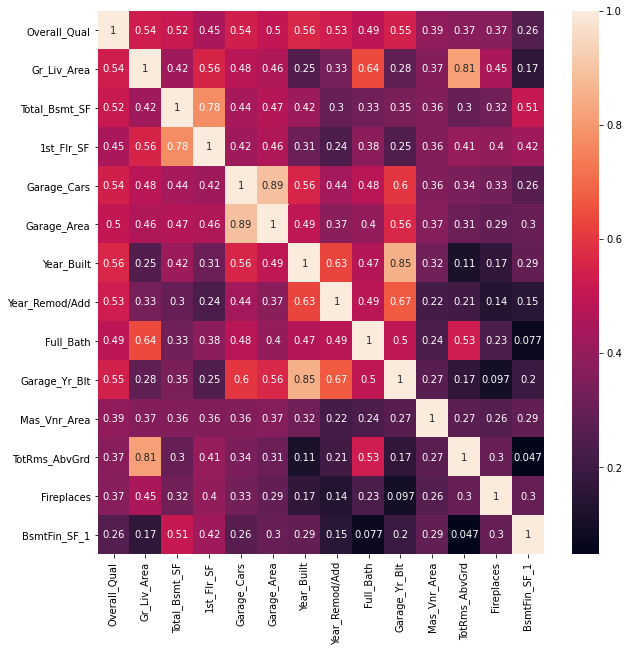

In [130]:
features=sale_price_corr.iloc[:14]

plt.figure(figsize=(10,10))
sns.heatmap(training_data[features.index].corr(),annot=True)

From observing the heat map, there were 5 variables that I decided to take out to minimize multicollinearity.

In [131]:
colinear=['TotRms_AbvGrd','Garage_Area','Year_Remod/Add','Full_Bath','Garage_Yr_Blt']

## Modeling

We will define our pipeline to create the dataframe that we will pass into our model.

*Idea from Data 200*

In [132]:
def select_columns(data, columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_fm(data):
    data = remove_outliers(data, 'Gr_Liv_Area', 5000)
    data = add_total_bathrooms(data)
    data=ohe_column(data,'Functional')
    data=ohe_column(data,'Exter_Qual')
    data=data.drop(data[data['Garage_Area'].isnull()].index)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    
    num_features=list(features.drop(colinear).index)
    other_features=['SalePrice', 
                   'TotalBathrooms', 
                   'in_rich_neighborhood',
                   'Exter_Qual_Fa', 
                'Exter_Qual_Gd', 
                'Exter_Qual_TA',
                'Functional_Min1',
                'Functional_Min2',
                'Functional_Mod',
                'Functional_Typ']
    overall_features=num_features+other_features
    
    data = select_columns(data, overall_features)
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    return X, y

### Ordinary Least Square

Read in the data again and split it into train and test data.

In [133]:
full_data = pd.read_csv('https://raw.githubusercontent.com/benchang123/Ames-Housing/master/ames.csv')

num_features=list(features.drop(colinear).index)
full_clean=full_data.drop(full_data.index[full_data[num_features].isnull().any(1)])

training_data, test_data = train_test_split(full_clean, random_state=42, test_size=0.25)

In [134]:
full_clean.shape

(1981, 82)

In [135]:
X_train,y_train=process_data_fm(training_data)
X_test,y_test=process_data_fm(test_data)

In [136]:
final_model = lm.LinearRegression()
final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

Determine the RMSE of our fit.

In [137]:
training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)
(training_rmse,test_rmse)

(28630.81248955582, 29111.281930012876)

Text(0, 0.5, 'RMSE')

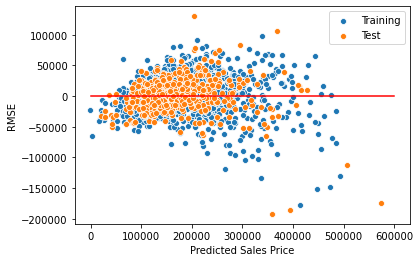

In [138]:
ax=sns.scatterplot(y_predicted_train,y_predicted_train-y_train,label="Training")
ax=sns.scatterplot(y_predicted_test,y_predicted_test-y_test,label="Test")
sns.lineplot([0,600000],0,color='red')

plt.legend(labels=['Training', 'Test'])
leg = ax.legend()
plt.xlabel('Predicted Sales Price')
plt.ylabel('RMSE')

Text(0, 0.5, 'Actual Sales Price')

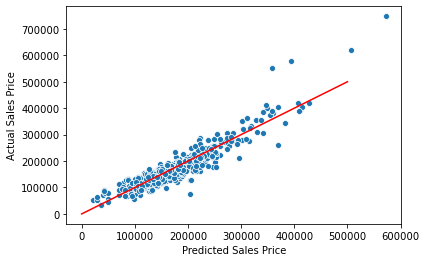

In [139]:
sns.scatterplot(y_predicted_test,y_test)
sns.lineplot([0,500000],[0,500000],color='red')

plt.xlabel('Predicted Sales Price')
plt.ylabel('Actual Sales Price')

### Ridge Regression

In [140]:
from sklearn import preprocessing

X_train_n,y_train_n=process_data_fm(training_data)
X_test_n,y_test_n=process_data_fm(test_data)

X_train_n = preprocessing.scale(X_train_n)
X_test_n = preprocessing.scale(X_test_n)

y_train_n=(y_train-np.mean(y_train))/np.std(y_train)
y_test_n=(y_test-np.mean(y_test))/np.std(y_test)

In [141]:
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
final_ridge = GridSearchCV(lm.Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
final_ridge.fit(X_train_n, y_train_n)
alpha = final_ridge.best_params_['alpha']
alpha

5.0

In [142]:
param_gridimp = {'alpha': list(np.linspace(5,25,500))}
final_ridgeimp = GridSearchCV(lm.Ridge(), cv=5, param_grid=param_gridimp, scoring='neg_mean_squared_error')
final_ridgeimp.fit(X_train_n, y_train_n)
alphaimp = final_ridgeimp.best_params_['alpha']
round(alphaimp,2)

5.0

In [143]:
y_ridge_train = final_ridgeimp.predict(X_train_n)
y_ridge_test = final_ridgeimp.predict(X_test_n)

In [144]:
training_rmse_ridge = rmse(y_ridge_train, y_train_n)
test_rmse_ridge = rmse(y_ridge_test, y_test_n)
(training_rmse_ridge,test_rmse_ridge)

(0.3486882570901344, 0.37151070752432697)

Text(0, 0.5, 'RMSE')

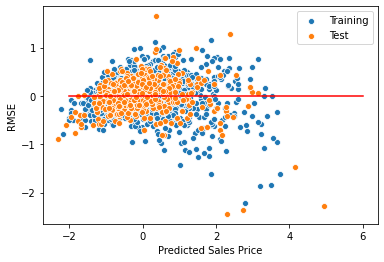

In [145]:
ax=sns.scatterplot(y_ridge_train,y_ridge_train-y_train_n,label="Training")
ax=sns.scatterplot(y_ridge_test,y_ridge_test-y_test_n,label="Test")
sns.lineplot([-2,6],0,color='red')

plt.legend(labels=['Training', 'Test'])
leg = ax.legend()
plt.xlabel('Predicted Sales Price')
plt.ylabel('RMSE')

Text(0, 0.5, 'Actual Sales Price')

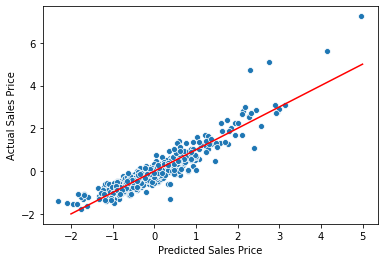

In [146]:
sns.scatterplot(y_ridge_test,y_test_n)
sns.lineplot([-2,5],[-2,5],color='red')

plt.xlabel('Predicted Sales Price')
plt.ylabel('Actual Sales Price')

### Lasso Regression

In [147]:
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
final_lasso = GridSearchCV(lm.Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
final_lasso.fit(X_train_n, y_train_n)
alpha = final_lasso.best_params_['alpha']
round(alpha,2)

0.01

In [148]:
param_gridimp = {'alpha': list(np.linspace(0.005,0.1,100))}
final_lassoimp = GridSearchCV(lm.Lasso(), cv=5, param_grid=param_gridimp, scoring='neg_mean_squared_error')
final_lassoimp.fit(X_train_n, y_train_n)
alphaimp = final_lassoimp.best_params_['alpha']
round(alphaimp,2)

0.0

In [149]:
final_lassoimp.fit(X_train_n, y_train_n)
y_lasso_train = final_lassoimp.predict(X_train_n)
y_lasso_test = final_lassoimp.predict(X_test_n)

In [150]:
training_rmse_lasso = rmse(y_lasso_train, y_train_n)
test_rmse_lasso = rmse(y_lasso_test, y_test_n)
(training_rmse_lasso,test_rmse_lasso)

(0.35067132496721615, 0.37099882924380145)

Text(0, 0.5, 'RMSE')

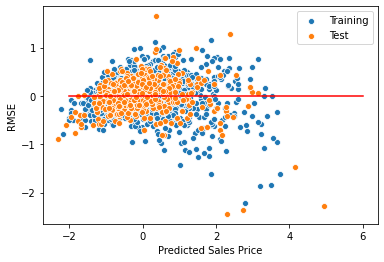

In [151]:
sns.lineplot([-2,6],0,color='red')
ax=sns.scatterplot(y_ridge_train,y_ridge_train-y_train_n,label="Training")
ax=sns.scatterplot(y_ridge_test,y_ridge_test-y_test_n,label="Test")

plt.legend(labels=['Training', 'Test'])
leg = ax.legend()
plt.xlabel('Predicted Sales Price')
plt.ylabel('RMSE')

Text(0, 0.5, 'Actual Sales Price')

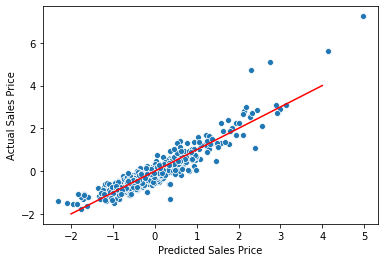

In [152]:
sns.scatterplot(y_ridge_test,y_test_n)
sns.lineplot([-2,4],[-2,4],color='red')

plt.xlabel('Predicted Sales Price')
plt.ylabel('Actual Sales Price')

# Conclusion

